In [3]:
# Imports
import pandas as pd
import numpy as np
import datetime
import math

##### Pull database from device to local machine

In [5]:
import subprocess
import time

subprocess.Popen("adb -d shell run-as com.example.iitqd cp databases/IITQD.db /sdcard/IITQD.db")
time.sleep(0.1) # wait for adb service to start
subprocess.Popen("adb -d pull /sdcard/IITQD.db .")

<Popen: returncode: None args: 'adb -d pull /sdcard/IITQD.db .'>

##### Import SQLite database from device database into dataframe and prepare dataframe
- This data is generated via human inputs into an android app, from which it is fetched when the device is connected to the PC
- (currently running on madeup data, as fetching proper data for X days takes X days of time and is still in process)

In [227]:
import sqlite3

db_location = "IITQD.db"
con = sqlite3.connect(db_location)

# Load the data into a DataFrame
diary_df = pd.read_sql_query("SELECT * from diary_table", con)

# Close the connection
con.close()

# create datetime column and restructure df
diary_df['datetime'] = pd.to_datetime(diary_df['DATE'] + " " + diary_df['TIME'])
diary_df = diary_df[['datetime', 'BLOODSUGAR', 'CARBUNITS', 'BOLUS', 'BASIS']]

# sort dataframe by datetime
diary_df = diary_df.sort_values(["datetime"])

# reset df indices
diary_df = diary_df.reset_index(drop=True)

print(diary_df)
print(diary_df.dtypes)

             datetime  BLOODSUGAR  CARBUNITS  BOLUS  BASIS
0 2021-07-21 00:34:00         123        5.0      5     55
1 2021-07-21 09:34:00         212        5.0      5     55
2 2021-07-21 20:34:00         555        5.0      5     55
3 2021-07-21 23:34:00         555        5.0      5     55
4 2021-07-22 20:34:00         555        5.0      5     55
datetime      datetime64[ns]
BLOODSUGAR             int64
CARBUNITS            float64
BOLUS                  int64
BASIS                  int64
dtype: object


##### Import exportet data from FreeStyle Libre 2 glucose measuring device into dataframe and prepare dataframe
- This data is fetched from a FSL2 device, which continuously scans an attached FSL2 sensor (roughly every 15minutes)

In [228]:
FL2_export_data = "FreeStyle Libre Export Data.txt"

# read .txt file into df
FL2_export_df = pd.read_csv(FL2_export_data,
                            sep='\s+', lineterminator='\r', skiprows=3, header=None, 
                            names=["id", "DATE", "TIME", "pointtype", "BLOODSUGAR"],
                           dtype={"DATE": str})

# merge DATE and TIME columns to datetime column
FL2_export_df['datetime'] = pd.to_datetime(FL2_export_df['DATE'] + " " + FL2_export_df['TIME'])

# sort dataframe by datetime
FL2_export_df = FL2_export_df.sort_values(["datetime"])

# reset df indices
FL2_export_df = FL2_export_df.reset_index(drop=True)

# drop rows with irregular BLOODSUGAR values marked by pointtype 6 or 7
FL2_export_df = FL2_export_df[(FL2_export_df.pointtype != 7) & (FL2_export_df.pointtype != 6) ]

# select relevant columns
FL2_export_df = FL2_export_df[['datetime', 'BLOODSUGAR']]

# drop last/empty line
FL2_export_df.dropna(how="all", inplace=True)


# # convert BLOODSUGAR to int64
FL2_export_df['BLOODSUGAR'] = FL2_export_df['BLOODSUGAR'].astype('int64')

print(FL2_export_df)
print(FL2_export_df.dtypes)

                 datetime  BLOODSUGAR
0     2021-07-20 21:25:00         129
1     2021-07-20 21:33:00         131
2     2021-07-20 21:40:00         125
3     2021-07-20 21:54:00         105
4     2021-07-20 22:05:00          90
...                   ...         ...
10461 2021-10-18 20:22:00          96
10462 2021-10-18 20:27:00          99
10463 2021-10-18 20:37:00         109
10464 2021-10-18 20:52:00         117
10465 2021-10-18 21:15:00         109

[10436 rows x 2 columns]
datetime      datetime64[ns]
BLOODSUGAR             int64
dtype: object


#### Generate labels data from mobile device SQL database data
- applicable for bloodsugar values after 3, 4 and 5hours 

In [229]:
# generate glucose level after 3h, 4h, 5h for the diary_df
def get_labels(df_FL2_export, df_diary, hours_passed=3):
    lower_minutes = hours_passed*60-10
    upper_minutes = hours_passed*60+10
    
    bloodsugar_x_hours = []

    for i in range (df_diary.shape[0]):
        date_time = df_diary.iat[i,0].to_pydatetime()

        lower_datetime = date_time + datetime.timedelta(minutes=lower_minutes)
        upper_datetime = date_time + datetime.timedelta(minutes=upper_minutes)

        mask = (df_FL2_export['datetime'] > lower_datetime) & (df_FL2_export['datetime'] < upper_datetime)
        df = df_FL2_export.loc[mask]
        bloodsugar_x_hours.append(df['BLOODSUGAR'].mean())
    column_name = "glucose_level_"+str(hours_passed)+"h"
#     bloodsugar_x_hours = [int(math.ceil(a)) for a in bloodsugar_x_hours]
#     bloodsugar_x_hours = [int(a) for a in bloodsugar_x_hours]
    return pd.DataFrame({column_name:bloodsugar_x_hours})
        

print(get_labels(FL2_export_df, diary_df, 3))
print(get_labels(FL2_export_df, diary_df, 4))
print(get_labels(FL2_export_df, diary_df, 5))

   glucose_level_3h
0             192.5
1             143.5
2             189.0
3             157.0
4             116.5
   glucose_level_4h
0             191.0
1             170.0
2             150.0
3             179.0
4             106.0
   glucose_level_5h
0             175.0
1             176.0
2             146.0
3             238.0
4             109.0


#### Prepare Data for Analysis/Visualizations and Machine Learning

In [242]:
# get diary data
data_prepared = diary_df.copy()

# add generated labels
data_prepared['BLOODSUGAR_3h'] = get_labels(FL2_export_df, diary_df, 3)

# remove data and seperator ':'
data_prepared['datetime'] = data_prepared['datetime'].dt.strftime('%H:%M')
data_prepared['datetime'] = data_prepared['datetime'].str.replace(':', '')

# remove leading 0s
data_prepared['datetime'] = data_prepared['datetime'].str.lstrip('0')

# transform string to int64
data_prepared['datetime'] = data_prepared['datetime'].astype('int64')


# restructure df
data_prepared.rename(columns={'datetime': 'TIME'}, inplace=True)
print(data_prepared)
print(data_prepared.dtypes)

   TIME  BLOODSUGAR  CARBUNITS  BOLUS  BASIS  BLOODSUGAR_3h
0    34         123        5.0      5     55          192.5
1   934         212        5.0      5     55          143.5
2  2034         555        5.0      5     55          189.0
3  2334         555        5.0      5     55          157.0
4  2034         555        5.0      5     55          116.5
TIME               int64
BLOODSUGAR         int64
CARBUNITS        float64
BOLUS              int64
BASIS              int64
BLOODSUGAR_3h    float64
dtype: object


In [153]:
### This is a leftover of 'made up realistic' data to test the following machine learning algorithm and data analysis steps
### This is a time fragment from before  the above automatisms to fetch actual data were existing
DATA_4DAYS = "data_4days.csv"
def load_iit_data(days=4):
    return pd.read_csv(DATA_4DAYS, sep = ';')

print("\nRunning main..")

# print("\nFetching iit data..")

print("\nLoading iit data..")
iit_data = load_iit_data(4)
print(iit_data)
print(iit_data.dtypes)
print(type(iit_data))


Running main..

Loading iit data..
    time  glucose_level  carbs_eaten  insulin_dosis  glucose_level_3h
0    800            110          4.5              8               170
1    800            100          3.0              6               150
2    800            200          4.0             10               160
3    800            250          5.0             13               150
4   1200            170          8.0              9                90
5   1200            150          6.0              7                78
6   1200            160          5.0              6                86
7   1200            150         12.0             13                75
8   1800            140          4.0              7                65
9   1800            180          3.0              6                80
10  1800            150          5.0              8               100
11  1800            130          5.0              8                80
time                  int64
glucose_level         int6

#### Vizualize/Analyze Data


Visualizing iit data.. 


----- iit data head -----
   TIME  BLOODSUGAR  CARBUNITS  BOLUS  BASIS  BLOODSUGAR_3h
0    34         123        5.0      5     55          192.5
1   934         212        5.0      5     55          143.5
2  2034         555        5.0      5     55          189.0
3  2334         555        5.0      5     55          157.0
4  2034         555        5.0      5     55          116.5


----- Data info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TIME           5 non-null      int64  
 1   BLOODSUGAR     5 non-null      int64  
 2   CARBUNITS      5 non-null      float64
 3   BOLUS          5 non-null      int64  
 4   BASIS          5 non-null      int64  
 5   BLOODSUGAR_3h  5 non-null      float64
dtypes: float64(2), int64(4)
memory usage: 368.0 bytes
None


----- Data Description -----
              TIME  B

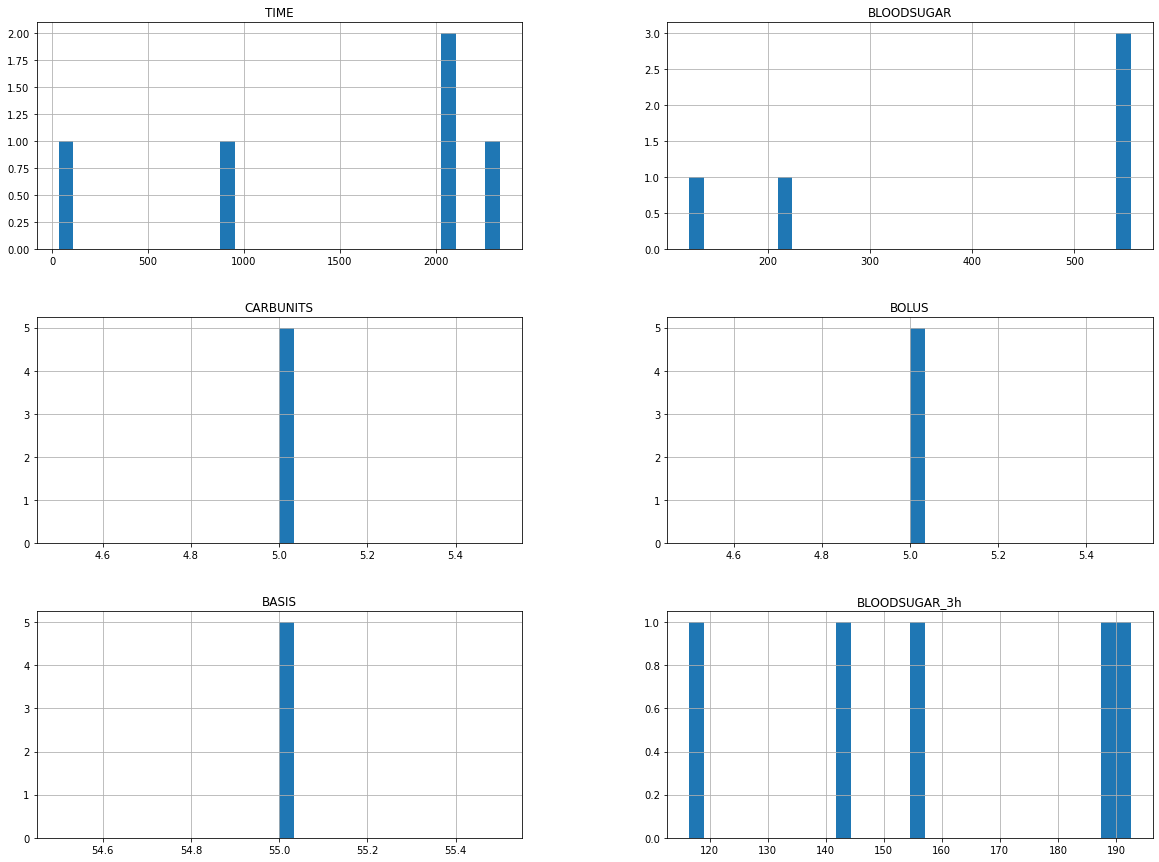



Plotting Time and glucose level after 3h as Ccatter Plot..


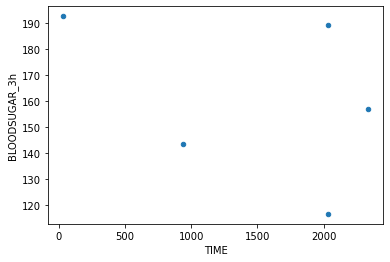



----- Correlation Matrix -----
BLOODSUGAR_3h    1.000000
BLOODSUGAR      -0.314599
TIME            -0.394242
CARBUNITS             NaN
BOLUS                 NaN
BASIS                 NaN
Name: BLOODSUGAR_3h, dtype: float64


Plotting Correlations..


C:\Users\fjun\anaconda3\envs\glpred\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 5.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\fjun\anaconda3\envs\glpred\lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical left == right == 55.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\fjun\anaconda3\envs\glpred\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical bottom == top == 5.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\fjun\anaconda3\envs\glpred\lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical left == right == 5.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundari

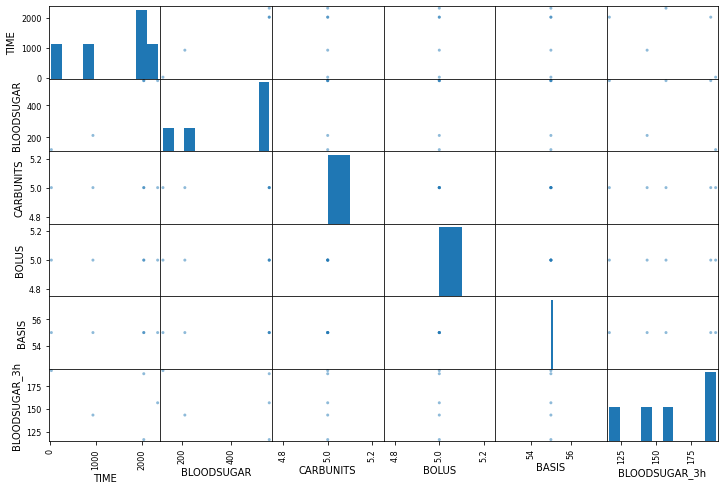

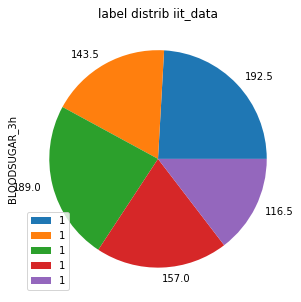

In [250]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
def analyze_data(iit_data):
    print("\n\n----- iit data head -----")
    print(iit_data.head())

    print("\n\n----- Data info -----")
    print(iit_data.info())

    print("\n\n----- Data Description -----")
    print(iit_data.describe())

    print("\nPlotting Features as Histograms..")
    iit_data.hist(bins=30, figsize=(20, 15))

    plt.show()

    print("\n\nPlotting Time and glucose level after 3h as Ccatter Plot..")
    iit_data.plot(kind="scatter", x="TIME", y="BLOODSUGAR_3h")

    plt.show()


    print("\n\n----- Correlation Matrix -----")
    corr_matrix = iit_data.corr()
    print(corr_matrix["BLOODSUGAR_3h"].sort_values(ascending=False))

    print("\n\nPlotting Correlations..")
    attributes = ["TIME", "BLOODSUGAR", "CARBUNITS", "BOLUS", "BASIS", "BLOODSUGAR_3h"]
    scatter_matrix(iit_data[attributes], figsize=(12, 8))

    plt.show()


    """\n\nPlotting Pie-Plot of labels.. """
    pie_data = iit_data.copy()
    pie_data.set_index(pd.Index(pie_data['BLOODSUGAR_3h']), inplace=True)
    counts = pie_data['BLOODSUGAR_3h'].value_counts()
#     print("Pie Data:", pie_data)
    pie_data.plot.pie(y='BLOODSUGAR_3h', figsize=(5, 5))  # , layout=(n_rows,n_cols), subplots=True)
    plt.title('label distrib iit_data')
    plt.legend(labels=counts.values, loc=3)

    plt.show()
    
print("Visualizing iit data.. ")
analyze_data(data_prepared)

#### Train a model
- currently training Linear Regression and Decision Tree Regression estimators

In [256]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

print("\nRunning main..")

# print("\nFetching iit data..")

print("\nLoading iit data..")
iit_data = data_prepared




print("\nSpliting data into Train and Test Set..")
data_train, data_test = train_test_split(iit_data, test_size=0.5)#, stratify=iit_data['TIME'])

print("\nSaving train and test sets")
data_train_dest = 'data_train.csv'
data_test_dest = 'data_test.csv'

data_train.to_csv(data_train_dest, index=False)
data_test.to_csv(data_test_dest, index=False)

print("\n----- iit_data shape -----\n", iit_data.shape)
print("\n----- data_train shape -----\n", data_train.shape)
print("\n----- data_test shape -----\n", data_test.shape)

print("\nindex: ", iit_data.index)

num_pipeline = Pipeline([
    # ('label_transformer', LabelTransformer(batch_labels=True)),
    ('std_scaler', StandardScaler()),
    # ('label_transformer', LabelTransformer()),
])

print("\n----- iit_data -----\n", iit_data)

data_train_pr = num_pipeline.fit_transform(data_train)

print("\n----- prepared data -----\n", data_train_pr)

print("\n----- X_pr -----\n")
X_train_pr = data_train_pr[:,:-1]
print(X_train_pr)

print("\n----- y_pr -----\n")
# y_train_pr = data_train_pr[:, -1]
y_train_pr = data_train[['BLOODSUGAR_3h']]
print(y_train_pr)


print("\nApplying Linear Regression and Testing on Test Set..")
lin_reg = LinearRegression()
lin_reg.fit(X_train_pr, y_train_pr)
data_test_pr = num_pipeline.fit_transform(data_test)
gl_predictions = lin_reg.predict(data_test_pr[:,:-1])
print("\nPredictions:\n", gl_predictions)
# print("\nLabels:\t\t", list(data_test_pr[:, -1]))
print("\nLabels:\n", list(data_test['BLOODSUGAR_3h']))

# lin_mse = mean_squared_error(list(data_test_pr[:, -1]), gl_predictions)
lin_mse = mean_squared_error(list(data_test['BLOODSUGAR_3h']), gl_predictions)
lin_mse = np.sqrt(lin_mse)
print("\n----- lin_mse -----\n", lin_mse)


print("\nApplying DecisionTreeRegressor and Testing on Test Set..")
tree_reg = DecisionTreeRegressor ()
tree_reg.fit(X_train_pr, y_train_pr)
data_test_pr = num_pipeline.fit_transform(data_test)
gl_predictions = tree_reg.predict(data_test_pr[:,:-1])
print("\nPredictions:\n", gl_predictions)
# print("\nLabels:\t\t", list(data_test_pr[:, -1]))
print("\nLabels:\n", list(data_test['BLOODSUGAR_3h']))

# tree_mse = mean_squared_error(list(data_test_pr[:, -1]), gl_predictions)
tree_mse = mean_squared_error(list(data_test['BLOODSUGAR_3h']), gl_predictions)
tree_mse = np.sqrt(tree_mse)
print("\n----- tree_mse -----\n", tree_mse)



Running main..

Loading iit data..

Spliting data into Train and Test Set..

Saving train and test sets

----- iit_data shape -----
 (5, 6)

----- data_train shape -----
 (2, 6)

----- data_test shape -----
 (3, 6)

index:  RangeIndex(start=0, stop=5, step=1)

----- iit_data -----
    TIME  BLOODSUGAR  CARBUNITS  BOLUS  BASIS  BLOODSUGAR_3h
0    34         123        5.0      5     55          192.5
1   934         212        5.0      5     55          143.5
2  2034         555        5.0      5     55          189.0
3  2334         555        5.0      5     55          157.0
4  2034         555        5.0      5     55          116.5

----- prepared data -----
 [[ 1.  0.  0.  0.  0.  1.]
 [-1.  0.  0.  0.  0. -1.]]

----- X_pr -----

[[ 1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.]]

----- y_pr -----

   BLOODSUGAR_3h
3          157.0
4          116.5

Applying Linear Regression and Testing on Test Set..

Predictions:
 [[135.09934323]
 [162.33517994]
 [112.81547683]]

Labels:
 [143.5, 1